In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import *

In [2]:
# the stakers where S[i] represents the total votes that the i-th staker has received, in AION.
S = [160, 80, 40, 30, 20, 10, 10, 10, 10, 10]
# in the NXT math paper, the balances are normalized; we do not do so to avoid a meaningless staking difficulty
#S = [x / sum(S) for x in S]
print("stakers:", S)

# the miners where M[i] represents the hash power of the i-th miner, in hashes/second.
M = [16, 8, 4, 3, 2, 1, 1, 1, 1, 1]
print("miners:", M)

stakers: [160, 80, 40, 30, 20, 10, 10, 10, 10, 10]
miners: [16, 8, 4, 3, 2, 1, 1, 1, 1, 1]


In [3]:
# number of iterations to run, in seconds
n = 30 * 24 * 60 * 60

# target block time, in seconds
t = 10

In [4]:
mean = -log(0.5) * 2 * t;
print("Ideal barrier:", mean);

mean = round(mean);
print("Ideal barrier after rounding to integer:", mean);

print("Actual targetd PoW/PoS block time:", mean / (-log(0.5)));

Ideal barrier: 13.862943611198906
Ideal barrier after rounding to integer: 14
Actual targetd PoW/PoS block time: 20.19773057244549


In [5]:
# the block chain
blocks = [] # (type, producer, timestamp, difficulty)

# the staking and mining target
target_s = 1
target_m = 1

# the timestamp of the last PoS block and PoW block
last_pos = -1
last_pow = -1

# the time delay of each staker
time_delay = []

# statistics: the block rewards of each staker and miner, blocks per second
rewards_s = np.zeros(len(S))
rewards_m = np.zeros(len(M))
forks = []

# returns a uniformly distributed value in [0, 1]
def u():
    return random.uniform(0, 1)

# Note: difficulty = 1 / target

# NXT target adjustment algorithm
def next_target_nxt(gamma, target, actual, expected):
    if actual >= 2 * expected:
        return target * 2
    elif actual >= 1 * expected:
        return target * actual / expected
    elif actual >= 0.5 * expected:
        return target - target * gamma * (expected - actual) / expected
    else:
        return target - target * gamma * 0.5

# Aion target adjustment algorithm
def next_target_aion(alpha, target, actual, expected):
    bar = round(-log(0.5) * expected)
    if actual > bar:
        return target * (1 + alpha)
    elif actual < bar:
        return target / (1 + alpha)
    else:
        return target

# simulate the block generation process, second-by-second
for i in range(n):
    
    # TODO: fine-tune the target adjustment algorithm
    aion_target_adj = True
    gamma = 1
    alpha = 0.01
    
    # TODO: fine-tune the logarithmic fix
    logarithmic_fix = False
    c0 = 0 
    c1 = 5
    c2 = 1
    
    # compute the time delay for every staker, if haven't done so
    if len(time_delay) == 0:
        for j in range(len(S)):
            d = abs(log(u())) / (target_s * S[j])
            if logarithmic_fix:
                d = c0 + c1 * log(1 + c2 * d)
            d = ceil(d)
            time_delay.append(d)
        #print("time delay:", time_delay)
    
    # print trace info
    if i % (12 * 60 * 60) == 0:
        print(i, target_s, target_m, time_delay)

    # check if any staker(s) is eligible to produce a block
    time_delay_min = min(time_delay)
    stakers = [j for j, x in enumerate(time_delay) if x == time_delay_min]
    if i - last_pos < time_delay_min:
        stakers = []
    
    # check if any miner(s) is able to find a solution
    miners = []
    for j in range(len(M)):
        for k in range(M[j]):
            if u() <= target_m:
                # a block is found by the j-th miner
                miners.append(j)
                break
    
    # update the stats
    forks.append(len(stakers) + len(miners))
    
    # neither the stakers nor the miners managed to produce a block
    if len(stakers) + len(miners) == 0:
        continue
    
    # now, they have to fight
    f = random.randint(0, len(stakers) + len(miners) - 1)
    if f < len(stakers):
        # append a PoS block
        staker = stakers[f]
        blocks.append(('s', staker, i, 1 / target_s))
        rewards_s[staker] += 1
        #print("forged by", staker, i)
        
        # adjust the staking target
        actual = i - last_pos
        expected = 2 * t
        if aion_target_adj:
            target_s = next_target_aion(alpha, target_s, actual, expected)
        else:
            target_s = next_target_nxt(gamma, target_s, actual, expected)
            
        # update the state
        last_pos = i
        time_delay = []
    else:
        # append a PoW block
        miner = miners[f - len(stakers)]
        blocks.append(('m', miner, i, 1 / target_m))
        rewards_m[miner] += 1
        #print("mined by", miner, i)
        
        # adjust the mining target
        actual = i - last_pow
        expected = 2 * t
        if aion_target_adj:
            target_m = next_target_aion(alpha, target_m, actual, expected)
        else:
            target_m = next_target_nxt(gamma, target_m, actual, expected)
            
        # update the state
        last_pow = i

print("Done!")

0 1 1 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
43200 0.00011799707221664258 0.0014921811386439494 [14, 44, 23, 373, 657, 55, 543, 554, 4806, 62]
86400 0.00013296205445600248 0.00137800424644224 [73, 63, 54, 286, 118, 321, 323, 91, 728, 95]
129600 0.00012278822651689785 0.0012474892678156944 [42, 111, 72, 612, 509, 3937, 2085, 623, 411, 510]
172800 0.0001252562698698875 0.0014921811386439494 [43, 96, 377, 354, 21, 366, 2088, 3429, 344, 1085]
216000 0.00014255331907105762 0.0013917842889066626 [15, 250, 175, 109, 73, 1180, 878, 80, 414, 698]
259200 0.00012278822651689785 0.001350852118853289 [26, 85, 199, 209, 184, 312, 1014, 790, 594, 135]
302400 0.00012905166010321496 0.0014627792752121844 [99, 73, 626, 259, 48, 2037, 48, 846, 63, 632]
345600 0.0001316455984712896 0.00137800424644224 [158, 95, 145, 328, 1260, 288, 2447, 314, 572, 1298]
388800 0.0001316455984712896 0.0014339567446448234 [92, 250, 752, 738, 802, 122, 186, 1339, 610, 1247]
432000 0.00013563459175056813 0.0015839803470172969 [49, 14

In [6]:
# Drop the first half to avoid the initial diff adjustment
blocks = blocks[len(blocks)//2:]

In [7]:
print("last 20 blocks:", blocks[-20:])
print("staker rewards:", rewards_s, sum(rewards_s))
print("miner rewards:", rewards_m, sum(rewards_m))
print("staking target:", target_s)
print("mining target:", target_m)

timestamps = [x[2] for i, x in enumerate(blocks)]
block_time = np.subtract(timestamps[1:], timestamps[:-1])
print("block time (last 10):", block_time[-10:])
print("block time mean:", np.mean(block_time))
print("block time std:", np.std(block_time))

pos_timestamps = [x[2] for i, x in enumerate(blocks) if x[0] == 's']
pos_block_time = np.subtract(pos_timestamps[1:], pos_timestamps[:-1])
print("PoS block time (last 10):", pos_block_time[-10:])
print("PoS block time mean:", np.mean(pos_block_time))
print("PoS block time std:", np.std(pos_block_time))

pow_timestamps = [x[2] for i, x in enumerate(blocks) if x[0] == 'm']
pow_block_time = np.subtract(pow_timestamps[1:], pow_timestamps[:-1])
print("PoW block time (last 10):", pow_block_time[-10:])
print("PoW block time mean:", np.mean(pow_block_time))
print("PoW block time std:", np.std(pow_block_time))

last 20 blocks: [('m', 4, 2591781, 676.8615242770449), ('m', 2, 2591795, 683.6301395198153), ('m', 0, 2591796, 683.6301395198153), ('m', 0, 2591808, 690.4664409150135), ('m', 2, 2591813, 697.3711053241636), ('s', 0, 2591836, 7904.586420539871), ('s', 0, 2591844, 7826.323188653338), ('s', 0, 2591865, 7904.586420539871), ('s', 2, 2591868, 7826.323188653338), ('s', 3, 2591879, 7904.586420539871), ('m', 7, 2591883, 704.3448163774053), ('m', 0, 2591887, 697.3711053241636), ('m', 0, 2591891, 704.3448163774053), ('m', 0, 2591921, 711.3882645411793), ('m', 0, 2591931, 704.3448163774053), ('m', 3, 2591942, 711.3882645411793), ('s', 1, 2591954, 7983.632284745269), ('m', 2, 2591960, 718.5021471865912), ('m', 1, 2591990, 711.3882645411793), ('m', 0, 2591991, 704.3448163774053)]
staker rewards: [ 54590.  27315.  13527.  10396.   6837.   3564.   3494.   3351.   3513.
   3523.] 130110.0
miner rewards: [ 54800.  27328.  13727.  10290.   6810.   3431.   3336.   3428.   3430.
   3441.] 130021.0
staking 

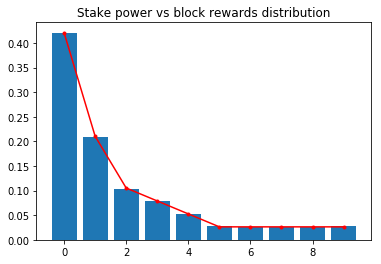

In [8]:
plt.bar(range(len(S)), rewards_s / sum(rewards_s));
plt.plot(range(len(S)), np.divide(S, sum(S)), color="r", marker=".");
plt.title("Stake power vs block rewards distribution");
plt.savefig("stake-power-vs-rewards.pdf")

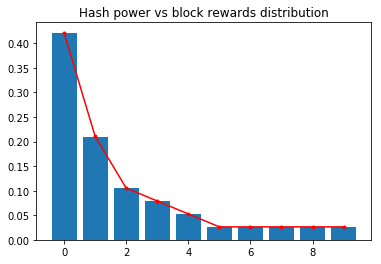

In [9]:
plt.bar(range(len(M)), rewards_m / sum(rewards_m));
plt.plot(range(len(M)), np.divide(M, sum(M)), color="r", marker=".");
plt.title("Hash power vs block rewards distribution");
plt.savefig("hash-power-vs-rewards.pdf")

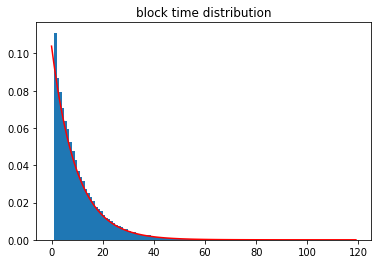

In [10]:
plt.hist(block_time, bins=range(120), density=1);
plt.title("block time distribution");

# the PDF of Exp(\lambda)
def pdf(l, x):
    return l * pow(e, -l * x)

pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 's']
pow_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 'm']

x = range(120)
y = np.vectorize(pdf)(sum(S) / np.mean(pos_diff) + sum(M) / np.mean(pow_diff), x)
plt.plot(x, y, color="red");

plt.savefig("block-time.pdf");

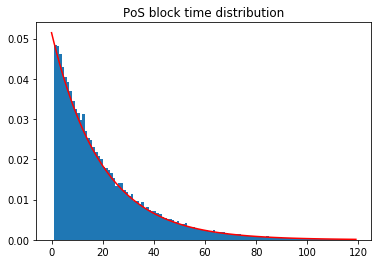

In [11]:
plt.hist(pos_block_time, bins=range(120), density=1);
plt.title("PoS block time distribution");

x = range(120)
y = np.vectorize(pdf)(sum(S)  / np.mean(pos_diff), x)
plt.plot(x, y, color="red");

plt.savefig("pos-block-time.pdf");

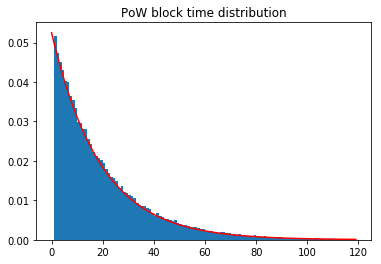

In [12]:
plt.hist(pow_block_time, bins=range(120), density=1);
plt.title("PoW block time distribution");

x = range(120)
y = np.vectorize(pdf)(sum(M)  / np.mean(pow_diff), x)
plt.plot(x, y, color="red");

plt.savefig("pow-block-time.pdf");

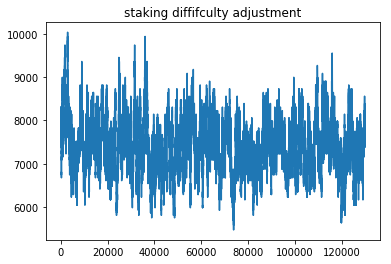

In [13]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 's']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 's']
plt.plot(pos_number, pos_diff);
plt.title("staking diffifculty adjustment");
plt.savefig("pos-diff.pdf")

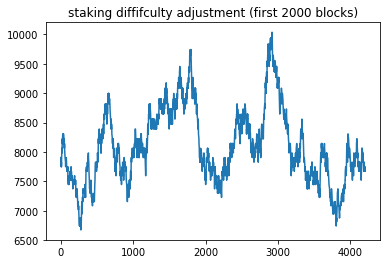

In [14]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 's']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 's']
interval = 2000;
plt.plot(pos_number[:interval], pos_diff[:interval]);
plt.title("staking diffifculty adjustment (first " + str(interval) + " blocks)");
plt.savefig("pos-diff-head.pdf")

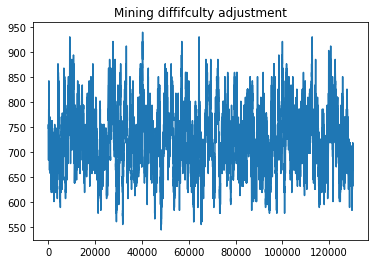

In [15]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 'm']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 'm']
plt.plot(pos_number, pos_diff);
plt.title("Mining diffifculty adjustment");
plt.savefig("pow-diff.pdf")

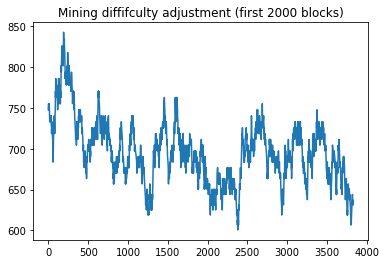

In [16]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 'm']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 'm']
interval = 2000;
plt.plot(pos_number[:interval], pos_diff[:interval]);
plt.title("Mining diffifculty adjustment (first " + str(interval) + " blocks)");
plt.savefig("pow-diff-head.pdf")

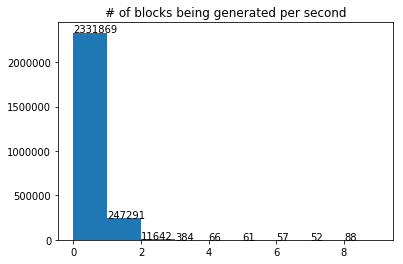

In [17]:
arr = plt.hist(forks, bins=range(10));
for i in range(9):
    plt.text(arr[1][i], arr[0][i] + 800, str(int(arr[0][i])))
plt.title("# of blocks being generated per second")
plt.savefig("forks.pdf")

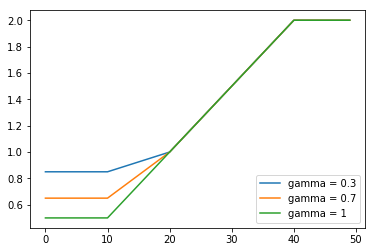

In [18]:
actual = range(0, 50, 1)
expected = 20

next_targets = np.vectorize(next_target_nxt)(0.3, 1, actual, expected)
plt.plot(actual, next_targets, label=("gamma = 0.3"));

next_targets = np.vectorize(next_target_nxt)(0.7, 1, actual, expected)
plt.plot(actual, next_targets, label=("gamma = 0.7"));

next_targets = np.vectorize(next_target_nxt)(1, 1, actual, expected)
plt.plot(actual, next_targets, label=("gamma = 1"));

plt.legend(loc='lower right')
plt.savefig("gamma.pdf")

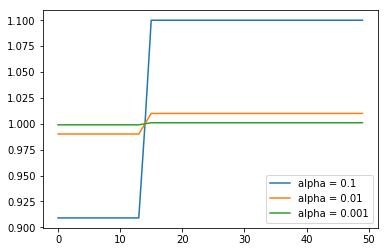

In [19]:
actual = range(0, 50, 1)
expected = 20

next_targets = np.vectorize(next_target_aion)(0.1, 1, actual, expected)
plt.plot(actual, next_targets, label=("alpha = 0.1"));

next_targets = np.vectorize(next_target_aion)(0.01, 1, actual, expected)
plt.plot(actual, next_targets, label=("alpha = 0.01"));

next_targets = np.vectorize(next_target_aion)(0.001, 1, actual, expected)
plt.plot(actual, next_targets, label=("alpha = 0.001"));

plt.legend(loc='lower right')
plt.savefig("alpha.pdf")